In [1]:
from abtem import __version__
print('current version:', __version__)

from abtem import *
from abtem.waves import FresnelPropagator, Waves
from ase.io import read

import numpy as np
import matplotlib.pyplot as plt
from ase import Atoms
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

current version: 1.0.0beta13


# Showing the 3d Wave function

<AxesSubplot:title={'center':'Side view'}, xlabel='x [Å]', ylabel='z [Å]'>

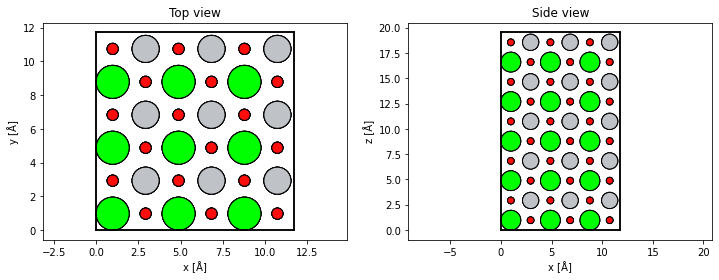

In [24]:
atoms = read('../data/srtio3_100.cif')

atoms *= (3, 3, 5)
atoms.center()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))

show_atoms(atoms, ax=ax1, title='Top view')
show_atoms(atoms, ax=ax2, plane='xz', title='Side view')

In [105]:
potential = Potential(atoms, sampling=.02, slice_thickness=.2, projection='infinite', parametrization='kirkland')

probe = Probe(energy=80e3, semiangle_cutoff=30)
probe.match_grid(potential)

# planewave = PlaneWave(energy=300e3) # uncomment of plane wave
# planewave.match_grid(potential) # uncomment of plane wave

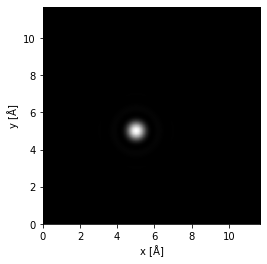

In [106]:
probe_position = (5,5) #atoms[2].position[:2]
#print(probe_position)
wave = probe.build(probe_position).show()

In [107]:
save_every = 1

propagator = FresnelPropagator()

probe_position = atoms[2].position[:2] # place probe on atom number 2
wave = probe.build(probe_position)

#wave = planewave.build() # uncomment of plane wave

wave3d = Waves(array=np.zeros((len(potential) // save_every,) + wave.gpts, dtype=np.complex64), 
               extent=wave.extent, energy=planewave.energy)

j = 0
for i, potential_slice in tqdm(enumerate(potential), total=len(potential)):
    
    potential_slice.transmit(wave)
    propagator.propagate(wave, potential_slice.thickness)
    
    if (i % save_every) == 0:
        wave3d.array[j] = wave.array
        j += 1

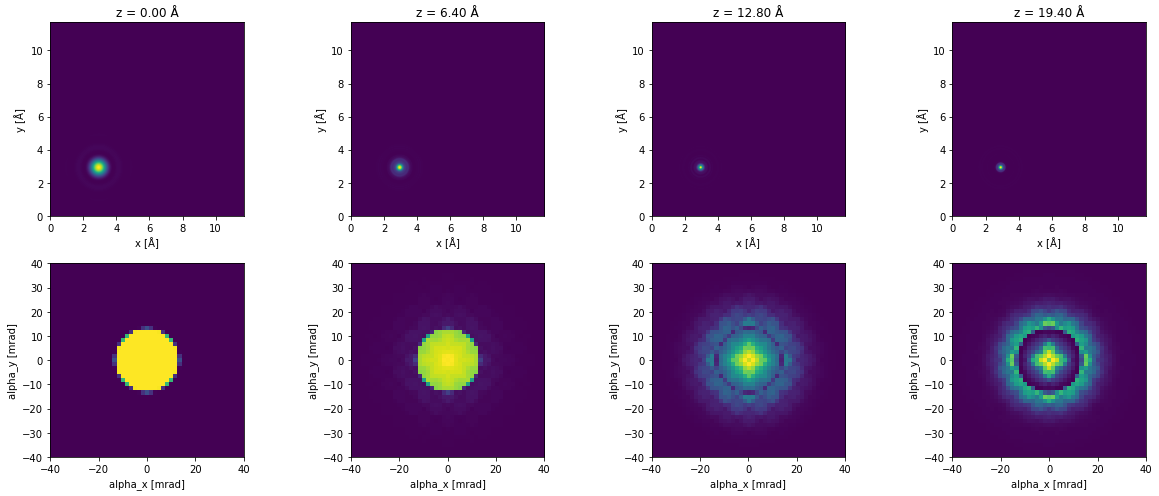

In [123]:
n = 4
fig, axes = plt.subplots(2, n, figsize=(17,7))

for i, ax in zip(np.linspace(0, len(potential)-1, n, dtype=int), axes.T):
    wave3d[i].intensity().show(cmap='viridis', ax=ax[0], title=f'z = {i * (save_every * potential.slice_thickness) :.2f} Å')
    wave3d[i].diffraction_pattern().show(cmap='viridis', ax=ax[1])
    
    ax[1].set_xlim([-40,40])
    ax[1].set_ylim([-40,40])

plt.tight_layout()

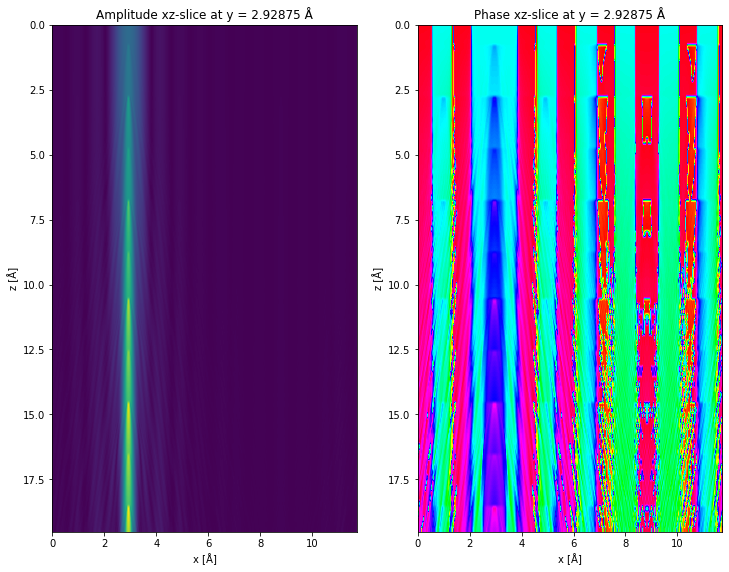

In [113]:
y = atoms[2].position[1]
y_idx = int(np.round(y / wave3d.sampling[1]))# + 15

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,12))
ax1.imshow((np.abs(wave3d.array))[:, :, y_idx], extent=[0, wave3d.extent[1], atoms.cell[2,2], 0])
ax2.imshow((np.angle(wave3d.array))[:, :, y_idx], extent=[0, wave3d.extent[1], atoms.cell[2,2], 0], cmap='hsv')

for ax, n in zip((ax1, ax2), ('Amplitude', 'Phase')):
    ax.set_title(f'{n} xz-slice at y = {y} Å')
    ax.set_xlabel('x [Å]')
    ax.set_ylabel('z [Å]');